Supplementary notebook to the manuscript "Unifying thermochemistry concepts in computational heterogeneous catalysis", by Dr. Bjarne Kreitz (Brown University), Dr. Gabriel Gusmao (Georgia Tech), Dr. David H. Bross (Argonne National Laboratory), Dingqi Nai (Georgia Tech), Jagriti Sahoo (Georgia Tech), Dr. C. Franklin Goldsmith (Brown University), Dr. Andrew J. Medford (Georgia Tech). 

Correspondence to Bjarne Kreitz (bjarne_kreitz@brown.edu) and Andrew J. Medford (ajm@gatech.edu)

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LinearRegression
from scipy import linalg

eV_to_kJmol=96.485

# Referencing DFT energies to least-squares elemental chemical potentials

For a typical DFT dataset, there is a myriad of possible anchor species to calculate the chemical potentials. As shown in the manuscript, different anchor species lead to different elemental chemical potentials and, thus, to different enthalpies of formation of the adsorbates. Instead of manually selecting the anchor species to determine the chemical potentials of the elements in a sequential approach, it is possible to exploit the invariance and select convenient numerical values for the chemical potentials. In particular, it is often convenient to select chemical potentials that minimize the (sum of squared) errors between enthalpies of formation computed using different codes, levels of fidelity, or reference sets. This can be achieved using linear algebra and least-squares regression and avoids the need to specify any explicit chemical species as anchors.

To calculate the least-squares anchor elemental potentials, we take the elemental composition matrix $\mathbf{\underline{\underline{N}}}$ that contains all the formation reactions of the target species from the constituent elements to derive the chemical potentials.
Rather than selecting a set of explicit anchor species with defined stoichiometries, we seek the set of chemical potentials that minimizes the squared magnitude of the resulting enthalpies of formation.
The linear algebra formulation offers a convenient way to perform the minimization of squared enthalpy of formation magnitudes, which is closely related to the least-squares regression problem and is given via

\begin{equation}
\mathbf{\underline{\mu}}^{LS}=\left(\mathbf{\underline{\underline{N}}}^{\intercal}\mathbf{\underline{\underline{N}}}\right)^{-1}\mathbf{\underline{\underline{N}}}^{\intercal}\mathbf{\underline{E}}=\mathbf{\underline{\underline{N}}}^{+}\, \mathbf{\underline{E}} \label{eq:regression}
\end{equation}

The least-squares regression result can also be written as the product of the pseudo-inverse of the elemental composition matrix $\mathbf{\underline{\underline{N}}}^{+}$  and the energy vector $\mathbf{\underline{E}}$.
Calculation of the enthalpies of formation is then performed by replacing the chemical potentials in the equation above, leading to
\begin{equation}
    \mathbf{\underline{H}}^{LS}_{f}=\mathbf{\underline{E}}-\mathbf{\underline{\underline{N}}}\, \mathbf{\underline{\mu}}^{LS}=\mathbf{\underline{E}}-\mathbf{\underline{\underline{N}}}\, \mathbf{\underline{\underline{N}}}^{+}\, \mathbf{\underline{E}}
\end{equation}
where we use the LS symbol to denote a least-squares anchor set that does not explicitly depend on specific molecular anchor species, but rather implicitly depends on the entire set of target species included (\textit{i.e.} the species in the rows of $\mathbf{\underline{\underline{N}}}$).

We first define the vector of DFT reaction energies $\mathbf{\underline{E}}$

In [144]:
#Target species for which we need to compute the EOFs
species_energies = {
    "X": -377616.072,
    "C2H6": -615.3019939,
    "H2O": -611.0186083,
    "CO2": -1414.682864,
    "C2H6X" : -378231.5655,
    "XCH2CH3": -378214.9168,
    "XO": -378193.2832,
    "XCH2XCH2": -378198.4442,  
    "XCO": -378453.0261, 
    "CO2X": -379030.8164,
    "XOH": -378209.8045,
    "H2OX": -378227.2801,    
    "XH": -377632.6636,
    "CO": -835.5389907,
    "C2H4":-581.44565067567,   
}

#vector of DFT energies of the target species from the dictionary
E=np.array(list(species_energies.values()))*eV_to_kJmol

We then construct the elemental composition matrix $\mathbf{\underline{\underline{N}}}$

In [143]:
# Define the species and their elemental compositions in a dictionary
species_compositions = {
    "X": {"C": 0, "H": 0, "O": 0, "X": 1}, 
    "C2H6": {"C": 2, "H": 6, "O": 0, "X": 0},
    "H2O": {"C": 0, "H": 2, "O": 1, "X": 0},    
    "CO2": {"C": 1, "H": 0, "O": 2, "X": 0},
    "C2H6X": {"C": 2, "H": 6, "O": 0, "X": 1},
    "XCH2CH3": {"C": 2, "H": 5, "O": 0, "X": 1},    
    "XO": {"C": 0, "H": 0, "O": 1, "X": 1},
    "XCH2XCH2": {"C": 2, "H": 4, "O": 0, "X": 1},    
    "XCO": {"C": 1, "H": 0, "O": 1, "X": 1},
    "CO2X": {"C": 1, "H": 0, "O": 2, "X": 1},
    "XOH": {"C": 0, "H": 1, "O": 1, "X": 1},
    "H2OX": {"C": 0, "H": 2, "O": 1, "X": 1},   
    "XH": {"C": 0, "H": 1, "O": 0, "X": 1},
    "CO": {"C": 1, "H": 0, "O": 1, "X": 0},
    "C2H4": {"C": 2, "H": 4, "O": 0, "X": 0},
}

species=list(species_compositions.keys())

# Create a matrix to hold the elemental compositions of the target species
num_species = len(species_compositions)
num_elements = 4  # C, H, O, X
N = np.zeros((num_species, num_elements))

# Fill in the elemental composition matrix of the target species
for s, composition in species_compositions.items():
    i = species.index(s)
    N[i, :] = [composition["C"], composition["H"], composition["O"], composition["X"]]
    
N

array([[0., 0., 0., 1.],
       [2., 6., 0., 0.],
       [0., 2., 1., 0.],
       [1., 0., 2., 0.],
       [2., 6., 0., 1.],
       [2., 5., 0., 1.],
       [0., 0., 1., 1.],
       [2., 4., 0., 1.],
       [1., 0., 1., 1.],
       [1., 0., 2., 1.],
       [0., 1., 1., 1.],
       [0., 2., 1., 1.],
       [0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [2., 4., 0., 0.]])

The chemical potential that minimizes the sum of squared differences of the resulting enthalpies of formation is computed using the pseudo-inverse

\begin{equation}
\mathbf{\underline{\mu}}^{LS}=\mathbf{\underline{\underline{N}}}^{+}\, \mathbf{\underline{E}} 
\end{equation}

In [89]:
#The chemical potentials are calculated with the pseudo-inverse of the elemental composition matrix. 
mu_LS = (linalg.pinv(N)).dot(E)

elements=['C','H','O','X']

#Create a dictionary with the results
chemical_potentials = {elements[i]: mu_LS[i] for i in range(len(elements))}

chemical_potentials

{'C': -24919.929953558047,
 'H': -1585.3403049171686,
 'O': -55770.66194749069,
 'X': -36434292.46914072}

It is then straightforward to calculate the enthalpies of formation of the species using the least-squares chemical potentials 

\begin{equation}
    \mathbf{\underline{H}}^{LS}_{f}=\mathbf{\underline{E}}-\mathbf{\underline{\underline{N}}}\, \mathbf{\underline{\mu}}^{LS}
\end{equation}

In [56]:
#Calculate the enthalpies of formation with the chemical potentials

Hf=E-N.dot(np.array(list(chemical_potentials.values())))

#Create a dictionary with the results
enthalpies_of_formation = {species[i]: Hf[i] for i in range(len(species))}
enthalpies_of_formation

{'X': 5.762220725417137,
 'C2H6': -15.511144822390634,
 'H2O': -12.787864500467549,
 'CO2': -34.4222845005861,
 'C2H6X': -28.226390160620213,
 'XCH2CH3': -7.216875575482845,
 'XO': 84.20153620839119,
 'XCH2XCH2': -3.1983694955706596,
 'XCO': -57.16221673041582,
 'CO2X': -34.597364738583565,
 'XOH': 75.48421062529087,
 'H2OX': -25.308750450611115,
 'XH': -9.738000363111496,
 'CO': 73.61238335924281,
 'C2H4': 80.43752134274837}

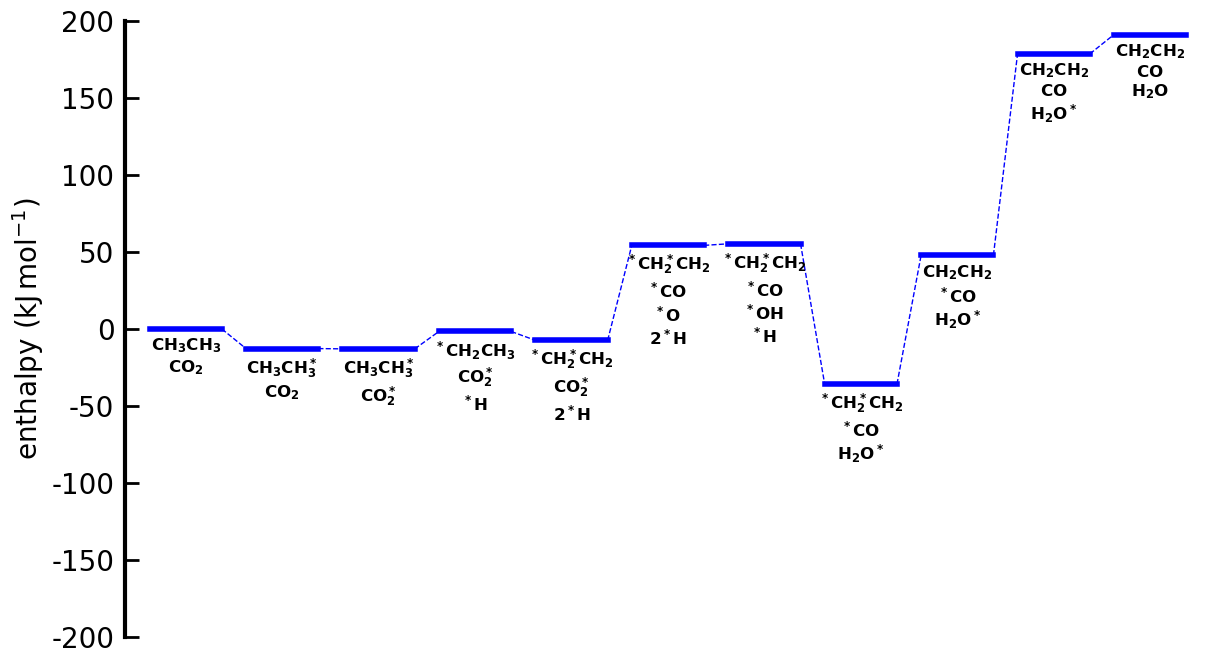

In [62]:
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.linewidth'] = 3
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams['ytick.major.pad'] = 8

gs = gridspec.GridSpec(nrows=1, ncols=1)
gs.update(wspace=0.5, hspace=0.5)
ax0 = plt.subplot(gs[0, 0])

ax0.set_ylim([-200,200])
ax0.set_xlim([-1,44])
ax0.get_xaxis().set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.set_ylabel('$\mathrm{enthalpy\ (kJ\,mol^{-1})}$')


mechanism=({'C2H6':1,'CO2':1},
    {'C2H6X':1,'CO2':1},
    {'C2H6X':1,'CO2X':1},
    {'XCH2CH3':1,'CO2X':1,'XH':1},
    {'XCH2XCH2':1,'CO2X':1,'XH':2},
    {'XCH2XCH2':1,'XCO':1,'XO':1,'XH':2},
    {'XCH2XCH2':1,'XCO':1,'XOH':1,'XH':1},
    {'XCH2XCH2':1,'XCO':1,'H2OX':1},
    {'C2H4':1,'XCO':1,'H2OX':1},
    {'C2H4':1,'CO':1,'H2OX':1}, 
    {'C2H4':1,'CO':1,'H2O':1},
    )

tags=('$\mathbf{CH_3CH_3}$\n$\mathbf{CO_2}$',
      '$\mathbf{CH_3CH_3^*}$\n$\mathbf{CO_2}$',
      '$\mathbf{CH_3CH_3^*}$\n$\mathbf{CO_2^*}$',
      '$\mathbf{^*CH_2CH_3}$\n$\mathbf{CO_2^*}$\n$\mathbf{^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{CO_2^*}$\n$\mathbf{2 ^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{^*O}$\n$\mathbf{2 ^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{^*OH}$\n$\mathbf{^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{H_2O^*}$',
      '$\mathbf{CH_2CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{H_2O^*}$',
      '$\mathbf{CH_2CH_2}$\n$\mathbf{CO}$\n$\mathbf{H_2O^*}$',
      '$\mathbf{CH_2CH_2}$\n$\mathbf{CO}$\n$\mathbf{H_2O}$',
)

# Function to compute the sum for each step in the mechanism
def compute_sum(vec,dictionary):
    return sum(vec[key] * value for key, value in dictionary.items())

def ediagram(ref_system):
    system = [compute_sum(ref_system,entry) for entry in mechanism]
    rel_EOFs=np.zeros(len(system))
    for i, Hf_i in enumerate(system):
        start = i * 4
        end = start + 3
        ax0.plot((start, end), (Hf_i-system[0], Hf_i-system[0]), linestyle='solid', color='b')
        if i>0:
            ax0.plot((start-1,start),(system[i-1]-system[0],Hf_i-system[0]),linestyle='dashed',color='b', linewidth=1)
        rel_EOFs[i]=Hf_i-system[0]
    return rel_EOFs

values=ediagram(enthalpies_of_formation)

for i in range(len(np.array(values).T)):
    start = i * 4
    ax0.text(start+1.5,np.array(values).T[i]-5,tags[i],va='top',ha='center',size=12)

In [59]:
#Alternatively, this can be formulated with a linear regression

def calculate_formation_energy(energy_dict, atoms_count_array):
    formation_en_dict = {}
    energy_array = np.array(list(energy_dict.values()))*eV_to_kJmol
    molecules = list(energy_dict.keys())
    reg = LinearRegression(fit_intercept = False)
    reg.fit(atoms_count_array, energy_array)
    predicted_energy = reg.predict(atoms_count_array)
    formation_energy = energy_array - predicted_energy

    for i, molecule in enumerate(molecules):
        formation_en_dict[molecule] = formation_energy[i]
        
    return formation_en_dict

formation_en = calculate_formation_energy(species_energies, N)
formation_en

{'X': 5.762220725417137,
 'C2H6': -15.51114482034609,
 'H2O': -12.787864482830628,
 'CO2': -34.42228447421803,
 'C2H6X': -28.226390153169632,
 'XCH2CH3': -7.216875568032265,
 'XO': 84.20153622329235,
 'XCH2XCH2': -3.198369488120079,
 'XCO': -57.16221671551466,
 'CO2X': -34.59736470878124,
 'XOH': 75.48421064019203,
 'H2OX': -25.308750435709953,
 'XH': -9.738000363111496,
 'CO': 73.61238337081159,
 'C2H4': 80.43752134195529}

In a more generic way, this can be formulated as determining corrections to a set of energies to align them with known energies of higher fidelity. 
In the case of two DFT datasets obtained from two different functionals, we can either compare the EOFs or determine atomic correction factors to align the energies of, e.g., the RPBE functional to align with the BEEF energy values. 
In fact, it can be shown that the least-squares anchor is also the anchor set that minimizes the sum of squared deviation between two different datasets obtained from different sources.
Thus, the minimum sum of squares chemical potentials can also be used directly to align data from different sources, e.g., from different functionals such as BEEF-vdW and RPBE or different levels of theory. 

\begin{equation}
    \mathbf{\underline{\hat{E}}}^{RPBE}=\mathbf{\underline{E}}^{RPBE}+\mathbf{\underline{\underline{N}}}\, \mathbf{\underline{\underline{N}}}^{+}\, \left(\mathbf{\underline{E}}^{BEEF-vdW}-\mathbf{\underline{E}}^{RPBE}\right)
\end{equation}

where $\mathbf{\underline{\hat{E}}}^{RPBE}$ are the aligned energies of the RPBE functional to the BEEF-vdW functional.
The equation allows to align the data from various sources to the same QM zero-of-energy, which is useful in data science and machine learning for providing an unbiased error between different levels of theory.

In [93]:
#The method can also be used to align different DFT data sets

species_energies_RPBE = { 
    "X": -366518.205,
    "C2H6": -600.361,
    "H2O": -600.7389158,
    "CO2": -1389.568,
    "C2H6X" : -367118.506,
    "XCH2CH3": -367102.198,
    "XO": -367085.354,
    "XCH2XCH2": -367086.181,  
    "XCO": -367339.346, 
    "CO2X": -367907.753,
    "XOH": -367101.878,
    "H2OX": -367118.949,    
    "XH": -366534.422,
    "CO": -819.812,
    "C2H4": -567.332,   
}

#vector of DFT energies of the target species from the dictionary
E_RPBE=np.array(list(species_energies_RPBE.values()))*eV_to_kJmol

In [96]:
#Calculate the DFT energies of RPBE aligned to the BEEF-vdW data with the chemical potentials

E_RPBE_aligned=E_RPBE+N.dot((linalg.pinv(N)).dot(E-E_RPBE))

#Create a dictionary with the results
DFT_RPBE_aligned = {species[i]: E_RPBE_aligned[i] for i in range(len(species))}
DFT_RPBE_aligned

{'X': -36434303.43239735,
 'C2H6': -59373.45291362446,
 'H2O': -58957.91270217598,
 'CO2': -136499.4476414965,
 'C2H6X': -36493671.09621097,
 'XCH2CH3': -36492056.46617737,
 'XO': -36489938.116766356,
 'XCH2XCH2': -36490469.913278766,
 'XCO': -36515044.887839854,
 'CO2X': -36570800.950338855,
 'XOH': -36491573.58755996,
 'H2OX': -36493261.83564857,
 'XH': -36435909.28229596,
 'CO': -80613.22687749541,
 'C2H4': -56104.34454141254}

In [139]:
#Calculate the difference between the DFT energies of BEEF-vdW and RPBE in kJ/mol

Delta_DFT_unaligned = {species[i]: E[i]-E_RPBE[i] for i in range(len(species))}
Delta_DFT_unaligned

{'X': -1070777.6974949986,
 'C2H6': -1441.5817964414964,
 'H2O': -991.8361308624953,
 'CO2': -2423.207653040008,
 'C2H6X': -1072243.545857504,
 'XCH2CH3': -1072210.6734180003,
 'XO': -1071748.5488620028,
 'XCH2XCH2': -1072166.7148519978,
 'XCO': -1072303.4244484976,
 'CO2X': -1073208.7721489966,
 'XOH': -1071748.2883525044,
 'H2OX': -1071787.326183498,
 'XH': -1070813.840776004,
 'CO': -1517.4186976894998,
 'C2H4': -1361.7555854420207}

In [138]:
#Calculate the difference between the DFT energies of BEEF-vdW and RPBE in kJ/mol

Delta_DFT_aligned = {species[i]: E[i]-E_RPBE_aligned[i] for i in range(len(species))}
Delta_DFT_aligned

{'X': 16.72547735273838,
 'C2H6': 6.0400321829656605,
 'H2O': 3.782280350482324,
 'CO2': 3.7715084564697463,
 'C2H6X': -1.5010565295815468,
 'XCH2CH3': -9.781270630657673,
 'XO': -40.812785647809505,
 'XCH2XCH2': -6.975358232855797,
 'XCO': 4.664581350982189,
 'CO2X': 12.629984855651855,
 'XOH': 0.6003774553537369,
 'H2OX': 2.7152000665664673,
 'XH': 21.734849952161312,
 'CO': -3.752640194084961,
 'C2H4': 3.5609359705194947}